# 1. Import Libraries 

In [1]:
import os
import glob
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

#Skorch
from skorch import NeuralNetClassifier, NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Distnce Matrix
from scipy.spatial import distance_matrix, distance

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from torch.utils.data import Dataset, DataLoader
#from sklearnex import patch_sklearn
#patch_sklearn()


# 2. Import Data

In [2]:
continous_vectordf = pd.read_csv("C:/Dissertation/Data/Processed Data/data_to_train_autoencoder.csv")
print(continous_vectordf.shape)
continous_vectordf.head()

(300000, 302)


,Unnamed: 0,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,</s>,0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.000420,-0.000576,0.001076,-0.001022,-0.000618,-0.000755,0.001404,-0.001640,-0.000633,0.001633,-0.001007,-0.001266,0.000652,-0.000416,-0.001076,0.001526,-0.000275,0.000140,0.001572,0.001358,-0.000832,-0.001404,0.001579,0.000254,-0.000732,-0.000105,-0.001167,0.001579,0.000656,-0.000660,0.000003,0.001129,0.000427,-0.000370,-0.001152,0.001266,-0.000004,0.000265,-0.000402,0.000141,-0.000034,0.000759,-0.000519,-0.000071,0.000603,-0.000507,-0.001625,-0.000437,-0.000992,-0.001221,-0.000322,0.000069,-0.001167,-0.000511,0.001411,0.000336,-0.000475,-0.001373,0.000366,-0.001442,-0.000607,0.000801,0.001129,-0.000835,-0.001160,0.000916,0.000523,-0.000328,0.001595,-0.001579,-0.000357,0.000496,0.001015,-0.001099,-0.000166,-0.000142,-0.000261,0.001259,0.000039,0.000169,-0.001030,0.001610,0.000629,0.000418,-0.001350,0.000349,0.001144,-0.001205,-0.001183,0.000950,0.000061,0.000011,-0.000668,0.001244,0.000690,0.000056,-0.000862,-0.001167,0.001213,-0.000805,-0.000877,0.000228,-0.000397,-0.000858,0.000288,-0.001587,0.000484,-0.001122,0.000002,-0.000380,0.000706,-0.001587,0.001625,0.001556,-0.000431,0.000984,0.000904,-0.001396,0.001205,-0.000702,0.000271,-0.001236,0.000690,-0.000843,0.001343,-0.001434,-0.000671,0.001549,-0.001099,0.001190,-0.001427,-0.000683,-0.000786,0.000481,0.000408,-0.000637,0.000145,-0.000977,0.001450,8.456409e-07,-0.001663,-0.000328,0.000629,-0.001434,-0.000341,0.001152,-0.000530,-0.000471,-0.000851,-0.001381,-0.001244,-0.001328,0.001076,0.001320,-0.000303,-0.000037,0.001183,-0.001358,-0.001045,0.000057,-0.001015,0.000433,-0.001572,-0.000091,0.001060,-0.000603,-0.001534,-0.001534,0.000542,0.001335,0.000412,-0.000311,0.000176,-0.000137,-0.000698,-0.000862,-0.001083,-0.000030,0.000801,0.000679,0.000336,-0.001389,0.001350,0.000235,-0.001335,-0.000874,-0.000744,0.001083,0.000061,-0.001266,0.001190,-0.000622,1.359731e-07,0.001274,-0.000984,-0.001549,0.001556,-0.001312,-0.000793,0.001534,0.001297,-0.000180,0.000919,0.001205,0.000771,-0.001656,0.000771,0.001450,-0.001305,0.000610,0.000660,0.001259,0.001419,-0.001221,-0.001511,0.001129,0.001343,0.001663,-0.000572,-0.000557,0.000399,-0.000271,0.000496,0.001610,-0.000706,0.000626,-0.000977,-0.000190,0.000095,-0.000519,-0.000204,-0.000828,-0.000123,0.000763,0.000322,-0.001244,0.000992,0.001060,-0.001411,0.000097,-0.001556,0.000219,-0.000055,-0.000912,-0.001488,0.001366,-0.000843,-0.000420,0.000324,-0.001007,0.000126,-0.000456,0.000193,-0.000269,0.001495,-0.001587,0.000591,-0.001465,0.000965,-0.001282,0.001602,0.001091,-0.001312,0.001091,-0.000511,0.000345,0.001045,-0.000207,0.000904,0.000668,0.001106,-0.000874,-0.000376,-0.000257,-0.000092,0.001434,-0.001183,-0.000087,0.001328,-0.000158,0.001289,-0.000984,-0.000549,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.001160,0.000568,-0.001564,-0.000123,-0.000086
1,10,was,0.0260

In [3]:
vector = continous_vectordf.iloc[:,2:].astype('float32')
classes = continous_vectordf['index']

# 3. Set up Autoencoder Architecture

### 3.1 Straight-Through Estimator Architecture

In [4]:
#https://discuss.pytorch.org/t/binary-activation-function-with-pytorch/56674/4
#https://hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight-through%20estimator%20is,function%20was%20an%20identity%20function.
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

class StraightThroughEstimator(nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x

### 3.1 Define DNN for projection network

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_units=300):
        super().__init__()
        self.num_units = num_units
        
        self.encode = nn.Sequential(
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, self.num_units),
            StraightThroughEstimator(), 
        )
        
    def forward(self, X):
        encoded = self.encode(X)
        return encoded

In [6]:
class Decoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.num_units = num_units
        
        self.decode = nn.Sequential(
            nn.Linear(self.num_units, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            #nn.Tanh(),
        )
        
    def forward(self, X):
        decoded = self.decode(X)
        return decoded

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.num_units = num_units

        self.encoder = Encoder(num_units=self.num_units)
        self.decoder = Decoder(num_units=self.num_units)
        
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded, encoded  # <- return a tuple of two values

In [8]:
class AutoEncoderNet(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        decoded, encoded = y_pred  # <- unpack the tuple that was returned by `forward`
        loss_reconstruction = super().get_loss(decoded, y_true)
        loss_l1 = 1e-3 * torch.abs(encoded).sum()
        return loss_reconstruction + loss_l1

In [9]:
# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
ES = EarlyStopping(monitor='valid_loss', patience=5, threshold=0.0001, threshold_mode='rel', lower_is_better=True)

In [10]:
torch.manual_seed(0)

net01 = AutoEncoderNet(
AutoEncoder,
module__num_units=300,
#iterator_train__shuffle=True, 
#iterator_valid__shuffle=True, 
batch_size= 512,
max_epochs= 50,
lr=.1,
criterion = nn.MSELoss(), 
optimizer=torch.optim.SGD,
optimizer__weight_decay = .001,
callbacks=[CP1, ES],
device='cuda'
)

In [11]:
X = vector.values
net01.fit(X, X)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.3280        1.3735     +  6.0111
      2        0.0260        0.7896     +  4.0664
      3        0.0169        0.5442     +  4.3332
      4        0.0133        0.4050     +  4.1964
      5        0.0116        0.3153     +  3.8817
      6        0.0107        0.2510     +  4.0641
      7        0.0100        0.2048     +  4.0127
      8        0.0097        0.1697     +  4.1633
      9        0.0095        0.1429     +  3.9069
     10        0.0093        0.1216     +  3.8906
     11        0.0092        0.1056     +  3.8996
     12        0.0091        0.0928     +  3.7902
     13        0.0091        0.0830     +  3.9642
     14        0.0090        0.0756     +  4.2039
     15        0.0090        0.0697     +  4.1463
     16        0.0090        0.0651     +  4.0359
     17        0.0090        0.0610     +  4.1430
     18        0.0090        0.0580     +  3.4623


<class '__main__.AutoEncoderNet'>[initialized](
  module_=AutoEncoder(
    (encoder): Encoder(
      (encode): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
        (1): ReLU()
        (2): Linear(in_features=300, out_features=300, bias=True)
        (3): StraightThroughEstimator()
      )
    )
    (decoder): Decoder(
      (decode): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
        (1): ReLU()
        (2): Linear(in_features=300, out_features=300, bias=True)
      )
    )
  ),
)

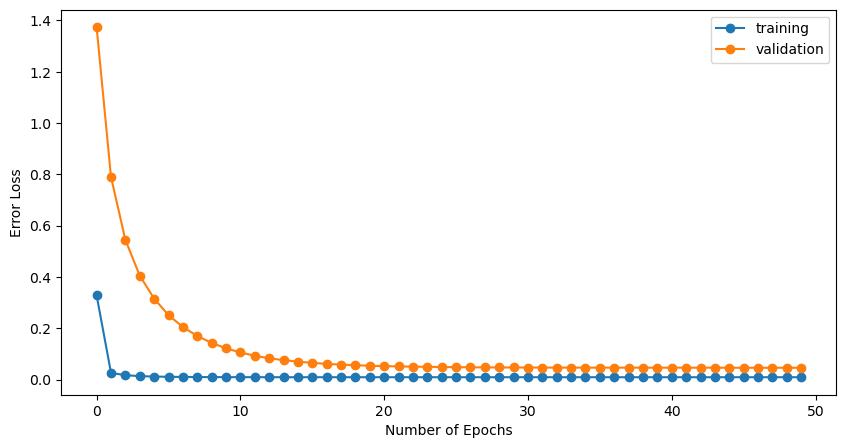

In [12]:
train_loss = net01.history[:, 'train_loss']
valid_loss = net01.history[:, 'valid_loss']
plt.figure(figsize=(10,5))
plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.xlabel('Number of Epochs', fontsize=10)
plt.ylabel('Error Loss', fontsize=10)
plt.legend()
plt.show() 

In [13]:
net01.load_params(checkpoint=CP1)

In [14]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [15]:
Word2Vec_Animal_vectors = pd.read_csv("C:/Dissertation/Data/Processed Data/Word2Vec_continous_vectors.csv")
Word2Vec_Animal_vectors.drop(['Unnamed: 0'],axis=1, inplace = True)
Word2Vec_Animal_vectors.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,labels,classes,word2vec_names
0,0.053711,0.310547,-0.287109,-0.115234,0.016968,-0.167969,-0.084961,0.056152,-0.077637,0.161133,0.306641,-0.043457,0.069336,-0.328125,0.083496,-0.201172,-0.173828,0.179688,-0.215820,-0.324219,-0.228516,-0.190430,0.067871,0.147461,-0.158203,-0.285156,-0.155273,0.093262,0.306641,-0.238281,0.039062,0.125000,-0.125000,-0.215820,-0.243164,0.163086,0.127930,0.023071,0.455078,0.384766,0.008789,0.027344,0.255859,0.155273,0.038086,-0.125977,0.190430,-0.044189,0.206055,0.011780,-0.132812,-0.412109,0.180664,-0.259766,0.203125,0.011841,0.030029,0.101074,0.062500,0.075684,-0.117676,-0.094238,0.000049,-0.244141,0.032227,-0.126953,0.168945,-0.201172,-0.226562,0.016357,-0.067383,-0.210938,-0.201172,-0.028076,-0.152344,-0.016968,-0.263672,-0.171875,-0.275391,0.031006,0.044678,-0.324219,0.017090,-0.053955,-0.049561,0.306641,-0.188477,0.269531,0.047363,0.049316,-0.057373,0.429688,0.009277,-0.093262,0.052734,-0.406250,0.345703,-0.149414,0.326172,-0.523438,0.103027,-0.160156,0.232422,-0.177734,0.363281,-0.008118,0.065430,0.149414,0.170898,0.039551,-0.166992,-0.192383,0.242188,0.228516,0.073730,0.012268,0.365234,-0.177734,-0.200195,-0.177734,-0.028687,-0.054932,-0.328125,-0.165039,-0.164062,0.098145,0.233398,0.203125,0.079590,-0.041504,-0.089355,0.092285,-0.215820,0.511719,-0.134766,0.040283,-0.427734,0.075684,0.050537,0.574219,0.018921,-0.273438,0.120605,0.251953,0.124512,0.130859,-0.367188,0.028687,-0.004333,-0.042236,0.320312,0.359375,-0.388672,-0.039307,0.042969,-0.112305,-0.077148,0.349609,-0.404297,-0.022583,-0.330078,0.099609,0.265625,0.125977,-0.145508,0.070801,0.326172,0.121094,-0.234375,0.251953,-0.242188,0.113281,-0.406250,0.141602,-0.151367,-0.184570,0.209961,-0.109375,0.144531,-0.159180,-0.699219,-0.277344,0.218750,-0.048096,-0.156250,0.182617,-0.059570,-0.285156,-0.318359,0.386719,-0.087891,-0.173828,-0.308594,0.090820,0.037598,0.129883,0.298828,-0.008240,-0.075195,0.201172,0.402344,-0.384766,0.092285,0.158203,-0.138672,0.026855,0.231445,-0.273438,0.071289,0.006714,-0.527344,-0.069824,-0.181641,-0.219727,-0.287109,0.486328,0.203125,0.065918,0.096191,-0.066406,0.119629,-0.018311,-0.174805,0.147461,0.255859,0.173828,0.166992,0.097656,0.257812,0.204102,-0.012207,-0.025757,-0.038330,0.184570,-0.132812,-0.036377,0.298828,0.412109,-0.084473,0.029053,0.070312,-0.330078,0.010193,-0.089844,0.047852,0.051758,-0.014587,-0.111816,0.176758,0.189453,-0.060059,0.255859,-0.108887,0.259766,-0.158203,0.029053,-0.109863,-0.196289,0.052246,-0.219727,-0.135742,-0.100098,0.425781,-0.093750,0.145508,0.201172,-0.175781,-0.016846,-0.170898,-0.007416,-0.146484,-0.029297,-0.369141,0.132812,0.384766,-0.283203,0.047363,0.013733,0.069336,-0.221680,-0.078613,-0.212891,-0.038818,-0.066406,-0.277344,-0.084473,0.131836,0.083984,0.328125,0.215820,-0.057617,-0.178711,-0.152344,0.257812,0.281250,0.326172,0.033447,0.185547,0.019287,0.101074,1,antelope,antelope
1,-0.006561

In [16]:
model = AutoEncoder(num_units = 300)
model.encoder.register_forward_hook(get_activation('encoder'))
output = model(torch.from_numpy(Word2Vec_Animal_vectors.iloc[:,:300].astype('float32').values))

binary_vector_df = pd.DataFrame(activation['encoder'].detach().numpy(), index=Word2Vec_Animal_vectors['classes'])
binary_vector_df = binary_vector_df.astype(int)
binary_vector_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
classes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
antelope,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,0,0,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,0
grizzly+bear,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,0
killer+whale,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0
beaver,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,1
dalmatian,1,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0

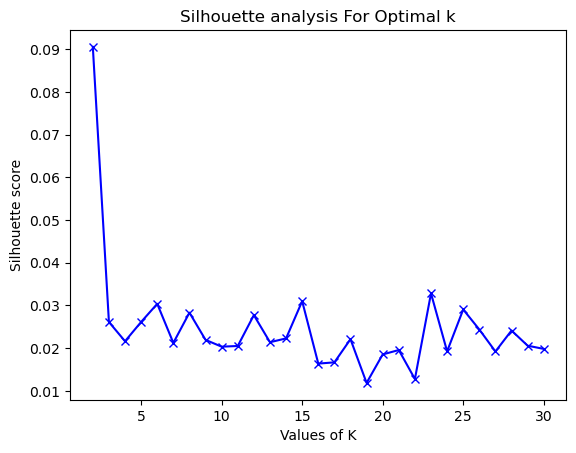

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30]
silhouette_avg = []
for num_clusters in range_n_clusters: 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(binary_vector_df)
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(binary_vector_df, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=23, random_state=0)
kmeans.fit(binary_vector_df)
clusters = kmeans.predict(binary_vector_df)
clusters_df = pd.DataFrame(data = clusters
             , columns = ['K_mean'])

In [19]:
#T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=0, random_state=50, metric = 'cosine', perplexity=15.0)
#binary
tsne_binary= tsne.fit_transform(binary_vector_df) 
tsne_binary_df = pd.DataFrame(data = tsne_binary
             , columns = ['binarycomp-1', 'binarycomp-2'])

#concat
tsne_binary_df1 = pd.concat([tsne_binary_df, Word2Vec_Animal_vectors['classes']], axis = 1)
tsne_binary_df1 = pd.concat([tsne_binary_df1, clusters_df['K_mean']], axis = 1)

In [20]:
source = tsne_binary_df1

points = alt.Chart(source).mark_circle(size=200).encode(
    x='binarycomp-1:Q',
    y='binarycomp-2:Q',
    color=alt.Color('K_mean:N', scale=alt.Scale(scheme='Magma'))
    ).properties(
    width=800,
    height=800
)

text1 = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).encode(
    text='classes:N'
)

text2 = points.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(
    text='K_mean:N'
)

points.interactive() + text1 + text2

alt.LayerChart(...)

In [190]:
binary_vector_df.reset_index(inplace = True)
temp_cols=binary_vector_df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
binary_vector_df=binary_vector_df[new_cols]
binary_vector_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,classes
0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,0,0,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,0,antelope
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,0,grizzly+bear
2,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,killer+whale
3,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,1,beaver
4,1,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1

In [191]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus,subgenus,biogeographicRealm,CMW_sciName
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope,NaN,Palearctic,Antilope_cervicapra
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus,NaN,Nearctic|Palearctic,Ursus_arctos
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus,NaN,Marine,Orcinus_orca
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia,NaN,Nearctic,Aplodontia_rufa
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis,NaN,Domesticated,Canis_familiaris


In [192]:
binary_attributes_df = pd.concat([binary_vector_df, taxonomy_df['order']], axis = 1)
binary_attributes_df = pd.concat([binary_attributes_df, taxonomy_df['family']], axis = 1)
binary_attributes_df = pd.concat([binary_attributes_df, clusters_df['K_mean']], axis = 1)
#binary_attributes_df.to_csv("C:\Dissertation\Data\Processed Data\Word2Vec_binary_vectors.csv")
binary_attributes_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,classes,order,family,K_mean
0,1,1,1,1,1,0,1,1,1,1,0,1,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,0,0,1,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,0,antelope,ARTIODACTYLA,BOVIDAE,6
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,1,0,1,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1,0,0,grizzly+bear,CARNIVORA,URSIDAE,0
2,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,killer+whale,ARTIODACTYLA,DELPHINIDAE,5
3,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,1,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,0,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,1,beaver,RODENTIA,APLODONTIIDAE,8
4,1,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,